In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import GPy

import numpy as np
import scipy as sp

In [2]:
X = np.linspace(0,12,21)[:,None]
Y = np.sin(X) + sp.randn(*X.shape)*0.1

m = GPy.models.GPRegression(X,Y)
m.optimize()
m

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.644573529217,+ve,,
rbf.lengthscale,1.47527509448,+ve,,
Gaussian_noise.variance,0.00212226843538,+ve,,


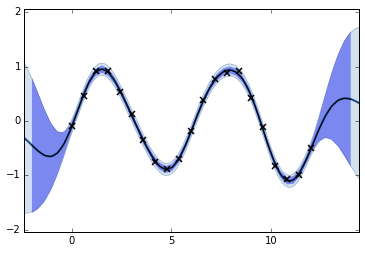

In [3]:
X2 = np.linspace(-2,14,51)[:,None]

Kx = m.rbf.K(X2, X).T

WiKx = np.dot(m.posterior.woodbury_inv, Kx)
mu = np.dot(Kx.T, m.posterior.woodbury_vector)

Kxx = m.rbf.Kdiag(X2)
var = Kxx - np.sum(WiKx*Kx, 0)
var = var.reshape(-1, 1)
var[var<0.] = 0.

m.plot()

#var += m.Gaussian_noise.variance

plt.fill_between(X2[:,0],(mu+2*np.sqrt(var))[:,0],(mu-2*np.sqrt(var))[:,0],
                 edgecolor='None',facecolor='blue',alpha=0.5)
plt.plot(X2[:,0],mu[:,0],'k');

In [4]:
import scipy.spatial.distance as dist
import scipy.linalg.lapack as lapack

[sf2, l2, sn2] = m

r = dist.pdist(X) / l2
K = dist.squareform(sf2 * np.exp(-0.5 * r**2))
np.fill_diagonal(K, sf2)

# add in Gaussian noise
Ky = K.copy()
np.fill_diagonal(Ky, sf2 + sn2 + 1e-8)

# compute the Cholesky factorization of our covariance matrix
LW, info = lapack.dpotrf(Ky, lower=True)
assert info == 0

# calculate lower half of inverse of K (assumes real symmetric positive definite)
Wi, info = lapack.dpotri(LW, lower=True)
assert info == 0

# make symmetric by filling in the upper half
Wi += np.tril(Wi,-1).T

# and solve
alpha, info = lapack.dpotrs(LW, Y, lower=True)
assert info == 0


Kx = sf2 * np.exp(-0.5 * (dist.cdist(X,X2) / l2)**2)

WiKx = np.dot(Wi, Kx)

mu = np.dot(Kx.T, alpha)
var = (sf2 - np.sum(WiKx*Kx, 0))[:,None]

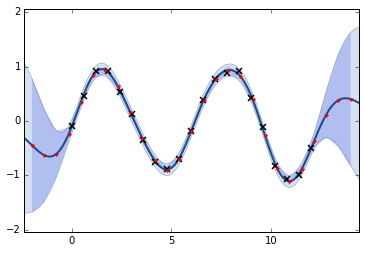

In [33]:
import csi.gp as gp

X2 = np.linspace(-2,14,27)[:,None]
(mu,var) = gp.rbf(X,Y,list(m)).predict(X2)

m.plot();

sn2 = m[2]

plt.fill_between(X2[:,0],(mu+2*np.sqrt(var))[:,0],(mu-2*np.sqrt(var))[:,0],
                 edgecolor='None',facecolor='blue',alpha=0.2)
plt.plot(X2[:,0],mu[:,0],'.r');